# 2. Predict Airbnb Price

# Section 1. Analyze Airbnb Data of San Franscisco

In [2]:
# import libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd


# basic setting
pd.set_option('display.max_columns', None)

### 1.1  Data Collection

In [174]:
# collect airbnb data
url_airbnb = "http://data.insideairbnb.com/united-states/ca/san-francisco/2023-09-02/data/listings.csv.gz"
airbnb_raw = pd.read_csv(url_airbnb, compression='gzip')

In [63]:
# collect neighborhood data

url_nhood = 'http://data.insideairbnb.com/united-states/ca/san-francisco/2023-09-02/visualisations/neighbourhoods.geojson'
nhood = gpd.read_file(url_nhood).to_crs(epsg=3857).drop('neighbourhood_group',axis=1)
nhood.head()

neighbourhood                                           geometry
0               Seacliff  MULTIPOLYGON (((-13634866.529 4549507.923, -13...
1         Haight Ashbury  MULTIPOLYGON (((-13629509.279 4546849.952, -13...
2          Outer Mission  MULTIPOLYGON (((-13631548.652 4538289.111, -13...
3  Downtown/Civic Center  MULTIPOLYGON (((-13626497.864 4549820.919, -13...
4        Diamond Heights  MULTIPOLYGON (((-13629460.632 4542967.028, -13...

In [5]:
len(nhood)

37

### 1.2  Data cleaning, formatting and transformation

In [64]:
# ==> Data Cleaning | filter 7 categories and 22 in total columns
columns=[
 # 1 index
 'id',
 'neighbourhood_cleansed',
 # 4 host info
 'host_since', # can translate to years
 'host_response_rate',
 'host_acceptance_rate',
 'host_identity_verified',
 # 2 location info
 'latitude',
 'longitude',
 # 3 core info that users mainly make decision on
 'price',
 'accommodates',
 'instant_bookable',
 # 4 room info
 'room_type',
 'beds',
 # 5 reviews info
 'number_of_reviews',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'last_review',
 'reviews_per_month',
 # 3 other info
 'calculated_host_listings_count',
 'minimum_nights',
 'maximum_nights']

airbnb=pd.DataFrame(airbnb_raw, columns=columns)

In [65]:
# ==> Data Cleaning |filter NA rows

# Print columns with missing values
missing_values = airbnb.isna().sum()
print(missing_values[missing_values > 0])

# delete NA
airbnb=airbnb.dropna(subset=["host_response_rate",
                             "host_acceptance_rate",
                             "beds",
                             "reviews_per_month",
                             "last_review",
                             "review_scores_rating"])

len(airbnb)

host_response_rate      1038
host_acceptance_rate     865
beds                     100
review_scores_rating    1437
last_review             1437
reviews_per_month       1437
dtype: int64


5153

In [66]:
# ==> Data Formatting

# 1.0 rename neighbourhood related column
airbnb=airbnb.rename(columns={"neighbourhood_cleansed":"neighbourhood"})

# 2.0 transform 'host_since' into datatime year
reference_date = pd.Timestamp('2023-12-18')
airbnb['host_year'] = pd.DatetimeIndex(airbnb['host_since']).year
airbnb.drop(columns=['host_since'], inplace=True)

# 3.0 transform 'last_review' into numeric values indicates days since last review
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'])
airbnb['last_review_days'] = (reference_date - airbnb['last_review']).dt.days
airbnb.drop(columns=['last_review'], inplace=True)

# 4.0 transform 'price' into numeric column
airbnb['price'] = airbnb['price'].str.extract('(\d+)', expand=False)
airbnb['price'] = airbnb['price'].astype(int)

# 5.0 transform 'host_response_rate' and 'host_acceptance_rate' into numeric column
airbnb['host_response_rate']= airbnb['host_response_rate'].str.extract('(\d+)', expand=False)
airbnb['host_response_rate'] = airbnb['host_response_rate'].astype(float)

airbnb['host_acceptance_rate']= airbnb['host_acceptance_rate'].str.extract('(\d+)', expand=False)
airbnb['host_acceptance_rate'] = airbnb['host_acceptance_rate'].astype(float)

# 6.0 convert the data type
airbnb['reviews_per_month'] = airbnb['reviews_per_month'].astype(float)
airbnb['accommodates'] = airbnb['accommodates'].astype(int)

# 7.0 calculate price per person 
airbnb['price_per_person']=airbnb["price"]/airbnb["accommodates"]

# 8.0 add the count field
airbnb["count"]=1

airbnb.head()

id     neighbourhood  host_response_rate  host_acceptance_rate  \
0   958  Western Addition               100.0                 100.0   
1  5858    Bernal Heights                80.0                  71.0   
2  8142    Haight Ashbury               100.0                  88.0   
3  8339  Western Addition               100.0                   0.0   
4  8739           Mission               100.0                  96.0   

  host_identity_verified  latitude  longitude  price  accommodates  \
0                      t  37.77028 -122.43317    187             3   
1                      t  37.74474 -122.42089    235             4   
2                      t  37.76555 -122.45213     56             1   
3                      t  37.77564 -122.43642    480             2   
4                      t  37.76030 -122.42197    122             3   

  instant_bookable        room_type  beds  number_of_reviews  \
0                f  Entire home/apt   2.0                405   
1                f  Entire home/apt   2.0                111   
2                f     Private room   1.0                 10   
3                f  Entire home/apt   1.0                 28   
4                f     Private room   1.0                792   

   number_of_reviews_l30d  review_scores_rating  reviews_per_month  \
0                       1                  4.87               2.36   
1                       0                  4.88               0.64   
2                       0                  4.70               0.09   
3                       0                  4.87               0.16   
4                       5                  4.92               4.62   

   calculated_host_listings_count  minimum_nights  maximum_nights  host_year  \
0                               1               2              30       2008   
1                               1              30              60       2009   
2                              15              32              90       2009   
3                               2               5              91       2009   
4                               2               1              26       2009   

   last_review_days  price_per_person  count  
0               133         62.333333      1  
1              2325         58.750000      1  
2               141         56.000000      1  
3              1634        240.000000      1  
4               119         40.666667      1

### 1.3 Table Distribution of San Franscisco Airbnb Data

In [73]:
import seaborn as sns

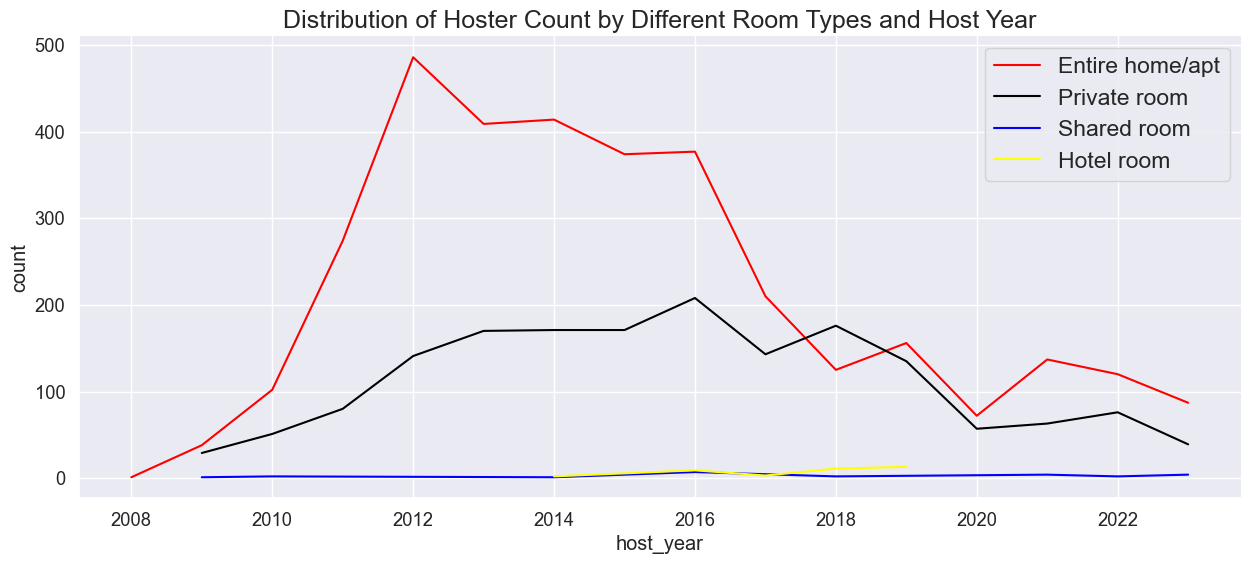

In [90]:
# Firstly, we investage the relationship between `host_year` and `room_type` via `counts`


# ==> 1.0 Data Wrangling

# group by the "host_year" and "room_type" columns and calculates the size (count) of each group 
group_year=airbnb.groupby(["host_year","room_type"]).size() 
# convert the series into a DataFrame
groupyear=pd.DataFrame(group_year)
# rename the column name
groupyear=groupyear.rename(columns={0:"count"})
# reset the index ( grouped dataframe usually will have a multi-level index which is inconvenient
groupyear=groupyear.reset_index()


# ==> 2.0 plot setting

# Initialize the figure and axes
fx,ax=plt.subplots(figsize=(15,6))

# Set the gtid style and font size
sns.set(style='darkgrid',font_scale=1.5)

# Set the color map
color_map = {"Entire home/apt": "red", "Private room": "black", "Shared room":"blue", "Hotel room":"yellow"}
colors = [color_map[room_type] for room_type in airbnb["room_type"]]
style = dict(palette=color_map)

# Plot the line
ax = sns.lineplot(x='host_year',y='count',hue="room_type",markers=True,data=groupyear,**style)

# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel="count",xlabel="host_year")

# Add a title
ax.set_title("Distribution of Hoster Count by Different Room Types and Host Year")
sns.despine(left=False, bottom=False)


# ==> 3.0 save plot
figure = ax.get_figure() 
figure.savefig("./diagram/host_year_count.png",bbox_inches='tight')

/var/folders/48/lbx6gdh15879t7nnkfxf04z00000gn/T/ipykernel_36709/3167881669.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(airbnb["price"],color="#990000")


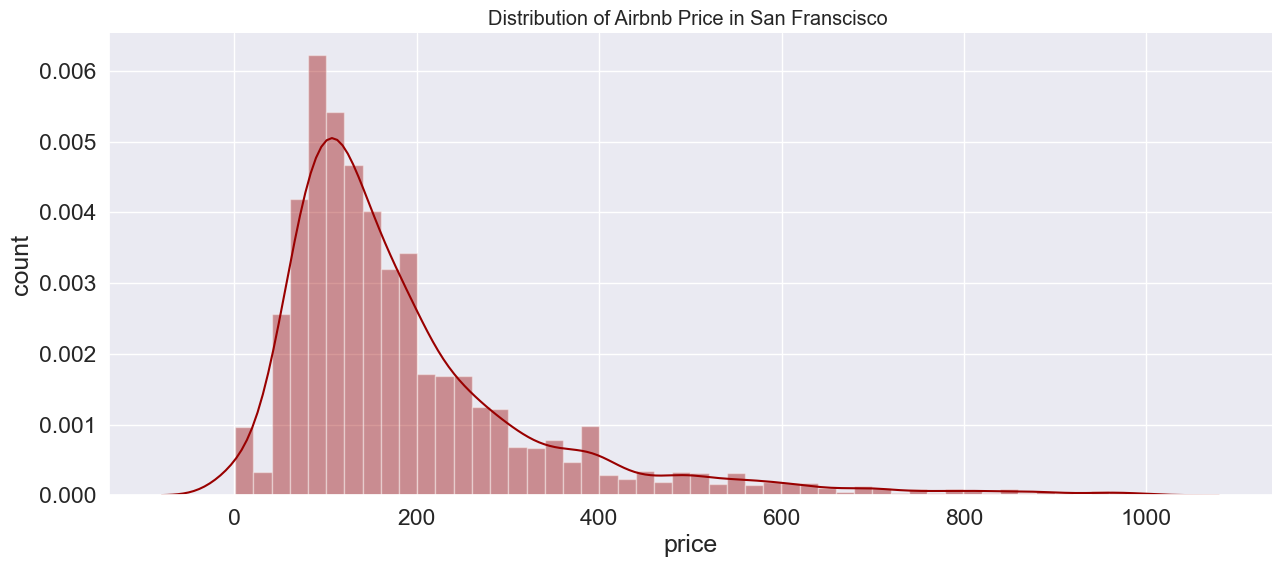

In [91]:
# Secondly, we investigate the distribution of price

# ==> 1.0 plot setting

# Initialize the figure and axes
fx,ax=plt.subplots(figsize=(15,6))
# Set the gtid style and font size
sns.set(style='darkgrid',font_scale=1.2)
# Plot the histogram
sns.distplot(airbnb["price"],color="#990000")
# Set the axis label
ax.set(ylabel="count",xlabel="price")
# Add a title
ax.set_title("Distribution of Airbnb Price in San Franscisco ")
sns.despine(left=False, bottom=False)


# ==> 2.0 plot setting
figure = ax.get_figure() 
figure.savefig("./diagram/distribution_price.png",bbox_inches='tight')

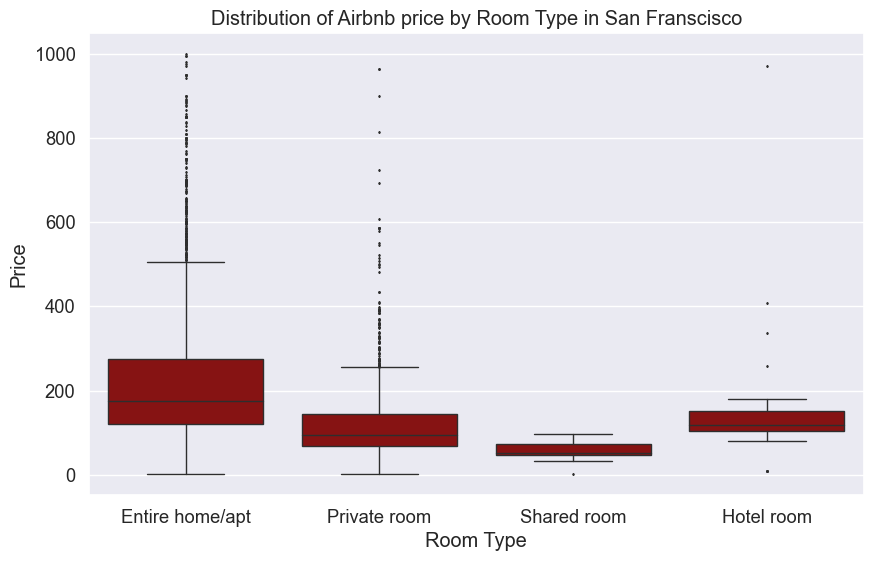

In [92]:
# Thirdly, we investigate the distribution of price by roomtype

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Set the Seaborn style and font size
sns.set(style='darkgrid', font_scale=1.2)

# Create a boxplot
sns.boxplot(x="room_type", y="price", data=airbnb, color="#990000", fliersize=1, linewidth=1, ax=ax)

# Set labels for y-axis and x-axis
ax.set(ylabel="Price", xlabel="Room Type")

# Add a title
plt.title("Distribution of Airbnb price by Room Type in San Franscisco")

# Show the plot
plt.show()

figure = ax.get_figure() 
figure.savefig("./diagram/distribution_price_byroomtype.png",bbox_inches='tight')

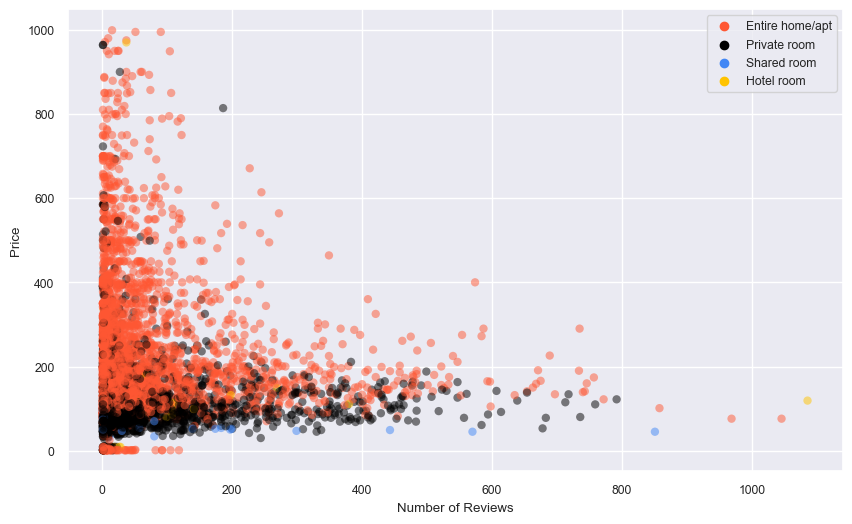

In [102]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Set the Seaborn style and font size
sns.set(style='darkgrid', font_scale=0.8)

# Define your color mapping dictionary
color_map = {"Entire home/apt": "#FF5733", "Private room": "#000000", "Shared room":"#4287f5", "Hotel room":"#FFC300"}

# Define style parameters
style = dict(palette=color_map, edgecolor="none", alpha=0.5)

# Plot the points using sns.scatterplot
sns.scatterplot(x="number_of_reviews", y="price", hue="room_type", data=airbnb, ax=ax, **style)

# Add a legend and informative axis labels
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel="Price", xlabel="Number of Reviews")

# Show the plot
plt.show()

figure = ax.get_figure() 
figure.savefig("./diagram/distribution_price_byreviews.png",bbox_inches='tight')

### 1.4 Spatial  Distribution of San Franscisco Airbnb Data

In [20]:
# define basemap in folium
import folium
from folium.plugins import HeatMap

def generateBaseMap_black(default_location=[37.7749, -122.4194], default_zoom_start=10):
    base_map = folium.Map(location=default_location, 
                          control_scale=True, 
                          zoom_start=default_zoom_start,
                          tiles='CartoDB dark_matter',
                          attr="default")
    return base_map

In [21]:
# plot the locations of Airbnb
base_map=generateBaseMap_black()

air_point = folium.map.FeatureGroup()
for lat, lng, in zip(airbnb.latitude, airbnb.longitude):
    air_point.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=1, # define how big the circle markers to be
            color="none",
            fill=True,
            fill_color='#339999',
            fill_opacity=0.4
        )
    )
    
folium_overview=base_map.add_child(air_point)
folium_overview.save("./diagram/spatial_distribution.html")

In [22]:
# calculate the airbnb count by neighborhood
nhood_count=airbnb.groupby(["nhood"])["count"].sum()
nhood_count=pd.DataFrame(nhood_count).reset_index()
nhood_count.head()

nhood  count
0              Bayview    131
1       Bernal Heights    244
2  Castro/Upper Market    231
3            Chinatown     84
4       Crocker Amazon     38

In [25]:
# visualize the airbnb count by neighbourhood
base_map=generateBaseMap_black()

nei_geo=f'{url_nhood}'
folium.Choropleth(
    geo_data=nei_geo,
    data=nhood_count,
    columns=['nhood','count'],
    key_on='feature.properties.neighbourhood',
    fill_color='GnBu',
    fill_opacity=0.8,
    line_color="#339999",
    line_opacity=1,
    highlight=True,
    legend_name='Airbnb Count by neighbourhood'
).add_to(base_map)

base_map.save("./diagram/spatial_distribution_bynhood.html")

# Section 2. Price Prediction for Airbnb Host in San Franscisco

## 2.1 Data Exploratory

In [87]:
# ==> 1.0 Convert the airbnb data into geodataframe
from shapely.geometry import Point

airbnb["coordinate"]=list(zip(airbnb["longitude"],airbnb["latitude"]))
airbnb["coordinate"]=airbnb["coordinate"].apply(Point)
airbnb_gpd=gpd.GeoDataFrame(airbnb,geometry="coordinate",crs={'init': 'epsg:4326'}).to_crs(epsg=3857)
airbnb_gpd.head()

/Users/watson/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


id     neighbourhood  host_response_rate  host_acceptance_rate  \
0   958  Western Addition               100.0                 100.0   
1  5858    Bernal Heights                80.0                  71.0   
2  8142    Haight Ashbury               100.0                  88.0   
3  8339  Western Addition               100.0                   0.0   
4  8739           Mission               100.0                  96.0   

  host_identity_verified  latitude  longitude  price  accommodates  \
0                      t  37.77028 -122.43317    187             3   
1                      t  37.74474 -122.42089    235             4   
2                      t  37.76555 -122.45213     56             1   
3                      t  37.77564 -122.43642    480             2   
4                      t  37.76030 -122.42197    122             3   

  instant_bookable        room_type  beds  number_of_reviews  \
0                f  Entire home/apt   2.0                405   
1                f  Entire home/apt   2.0                111   
2                f     Private room   1.0                 10   
3                f  Entire home/apt   1.0                 28   
4                f     Private room   1.0                792   

   number_of_reviews_l30d  review_scores_rating  reviews_per_month  \
0                       1                  4.87               2.36   
1                       0                  4.88               0.64   
2                       0                  4.70               0.09   
3                       0                  4.87               0.16   
4                       5                  4.92               4.62   

   calculated_host_listings_count  minimum_nights  maximum_nights  host_year  \
0                               1               2              30       2008   
1                               1              30              60       2009   
2                              15              32              90       2009   
3                               2               5              91       2009   
4                               2               1              26       2009   

   last_review_days  price_per_person  count  \
0               133         62.333333      1   
1              2325         58.750000      1   
2               141         56.000000      1   
3              1634        240.000000      1   
4               119         40.666667      1   

                          coordinate  
0  POINT (-13629198.141 4547024.716)  
1  POINT (-13627831.137 4543428.629)  
2  POINT (-13631308.758 4546358.628)  
3  POINT (-13629559.929 4547779.573)  
4  POINT (-13627951.362 4545619.363)

/var/folders/48/lbx6gdh15879t7nnkfxf04z00000gn/T/ipykernel_1960/2470584149.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  chart=sns.distplot(airbnb_gpd['price'], ax=axes[0],color="#990000")
/var/folders/48/lbx6gdh15879t7nnkfxf04z00000gn/T/ipykernel_1960/2470584149.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

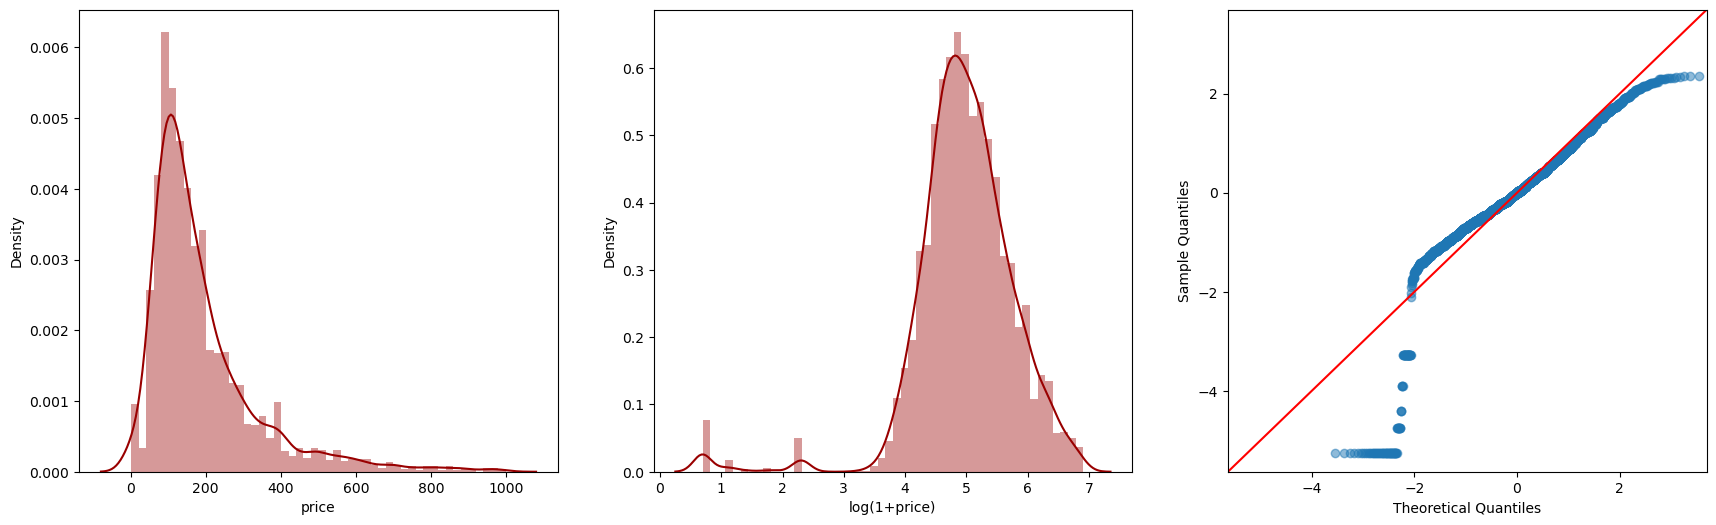

In [27]:
# ==> Clean the airbnb_gpd data
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import scipy.stats as stats

fig, axes = plt.subplots(1,3, figsize=(21,6))
# 
chart=sns.distplot(airbnb_gpd['price'], ax=axes[0],color="#990000")
chart=sns.distplot(np.log1p(airbnb_gpd['price']), ax=axes[1],color="#990000")
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(airbnb_gpd['price']), stats.norm, fit=True, line='45',color="#990000",alpha=0.5,ax=axes[2])

figure = chart.get_figure() 
figure.savefig("./diagram/price_histogram.png",bbox_inches='tight')

In [28]:
airbnb_gpd = airbnb_gpd [(np.log1p(airbnb_gpd ['price']) < 8) & (np.log1p(airbnb_gpd ['price']) >3)]
airbnb_gpd=airbnb_gpd.dropna()

In [29]:
len(airbnb_gpd)

5054

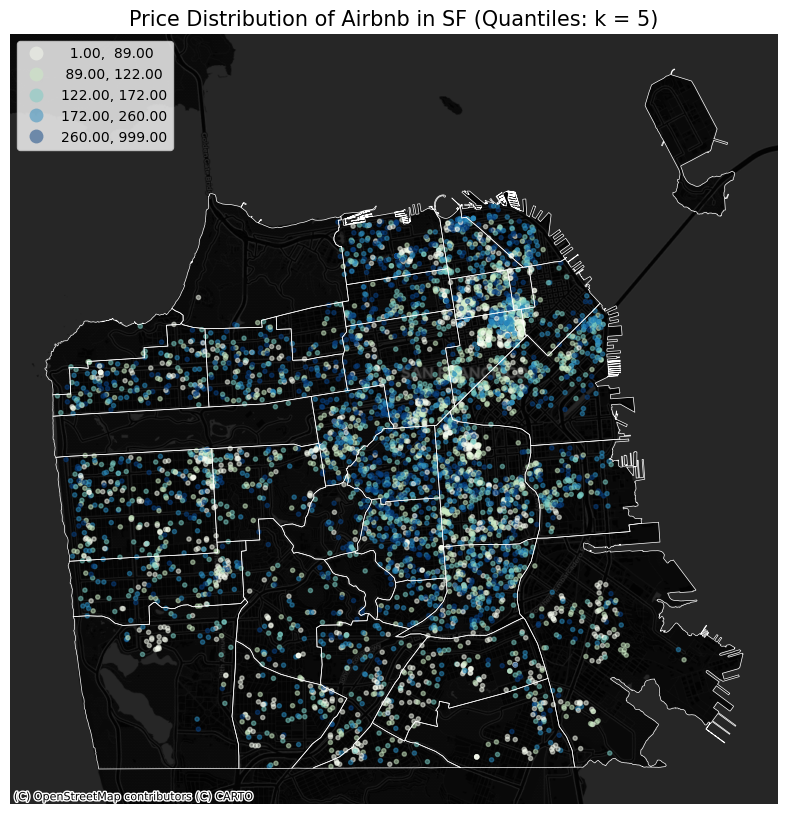

In [225]:
import contextily as ctx

# create the axes
fig, ax = plt.subplots(figsize=(10, 10))

# plot a random sample of potholes
airbnb_gpd.plot(ax=ax, 
                marker='.', 
                column="price" ,
                cmap="GnBu",
                alpha=0.5,
                legend=True,
                legend_kwds=dict(loc='upper left'),
                scheme="Quantiles",
                k=5) 

# add the Neighbor boundary
nhood.plot(ax=ax, edgecolor='white', linewidth=0.5, facecolor='none')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=airbnb_gpd.crs, source=ctx.providers.CartoDB.DarkMatter)

#CartoDB.Positron
# remove axis lines
ax.set_title("Price Distribution of Airbnb in SF (Quantiles: k = 5)",fontsize=15)
ax.set_axis_off()
ax.set_aspect("equal")
plt.savefig('./diagram/detail/price_points',bbox_inches='tight')

In [67]:
# spatial join
airbnb_nhood=gpd.sjoin(airbnb_gpd,nhood,op="within",how="right")
airbnb_nhood.reset_index().head()

/Users/watson/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


index  index_left            id     nhood  host_response_rate  \
0      0       518.0  2.254431e+06  Seacliff               100.0   
1      0      1048.0  8.352275e+06  Seacliff               100.0   
2      0      6146.0  7.689811e+17  Seacliff               100.0   
3      0      1844.0  1.958800e+07  Seacliff               100.0   
4      0      1610.0  1.657052e+07  Seacliff               100.0   

   host_acceptance_rate host_identity_verified  latitude  longitude  price  \
0                  98.0                      t  37.77641 -122.50991  535.0   
1                  98.0                      t  37.78006 -122.50905  134.0   
2                 100.0                      t  37.78247 -122.49269  107.0   
3                 100.0                      t  37.78449 -122.48855  429.0   
4                 100.0                      t  37.78732 -122.49336  154.0   

   accommodates instant_bookable        room_type  beds  number_of_reviews  \
0           8.0                f  Entire home/apt   4.0               51.0   
1           2.0                t     Private room   1.0              718.0   
2           3.0                f  Entire home/apt   2.0               45.0   
3           5.0                f  Entire home/apt   3.0               24.0   
4           2.0                f     Private room   1.0              148.0   

   number_of_reviews_l30d  review_scores_rating  reviews_per_month  \
0                     0.0                  4.90               0.45   
1                     5.0                  4.94               7.41   
2                     5.0                  4.93               5.23   
3                     0.0                  4.96               0.34   
4                     3.0                  4.88               1.86   

   calculated_host_listings_count  minimum_nights  maximum_nights  host_year  \
0                             2.0             1.0          1125.0     2014.0   
1                             2.0             1.0          1125.0     2014.0   
2                             1.0             1.0            28.0     2022.0   
3                            18.0             3.0            21.0     2011.0   
4                             1.0             2.0            14.0     2014.0   

   last_review_days  price_per_person  count neighbourhood  \
0             211.0         66.875000    1.0      Seacliff   
1             112.0         67.000000    1.0      Seacliff   
2             122.0         35.666667    1.0      Seacliff   
3             138.0         85.800000    1.0      Seacliff   
4             108.0         77.000000    1.0      Seacliff   

                                            geometry  
0  MULTIPOLYGON (((-13634866.529 4549507.923, -13...  
1  MULTIPOLYGON (((-13634866.529 4549507.923, -13...  
2  MULTIPOLYGON (((-13634866.529 4549507.923, -13...  
3  MULTIPOLYGON (((-13634866.529 4549507.923, -13...  
4  MULTIPOLYGON (((-13634866.529 4549507.923, -13...

In [226]:
# calculate the airbnb count by neighborhood
group=airbnb.groupby(["neighbourhood"])["price"].mean()
group=pd.DataFrame(group).reset_index()

group=nhood.merge(group,on="neighbourhood")
group=group.rename(columns={0:"count"})


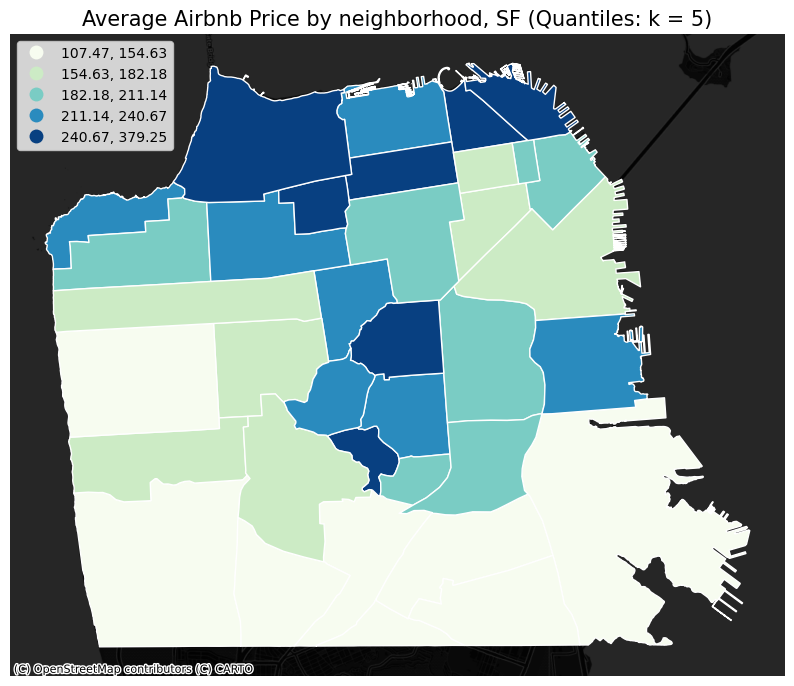

In [227]:
# Needed to line up the colorbar properly
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10),facecolor="white")

# Plot
group.plot( ax=ax,
    column="price",
    edgecolor="white",
    legend=True,
    legend_kwds=dict(loc='upper left'),
    cmap="GnBu",
    scheme="Quantiles",
    k=5)

# Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = group.total_bounds

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=airbnb_gpd.crs, source=ctx.providers.CartoDB.DarkMatter)

# Format
ax.set_title("Average Airbnb Price by neighborhood, SF (Quantiles: k = 5)",size=15)
ax.set_axis_off()
ax.set_aspect("equal")
plt.savefig('./diagram/detail/price_average_nhood',bbox_inches='tight')

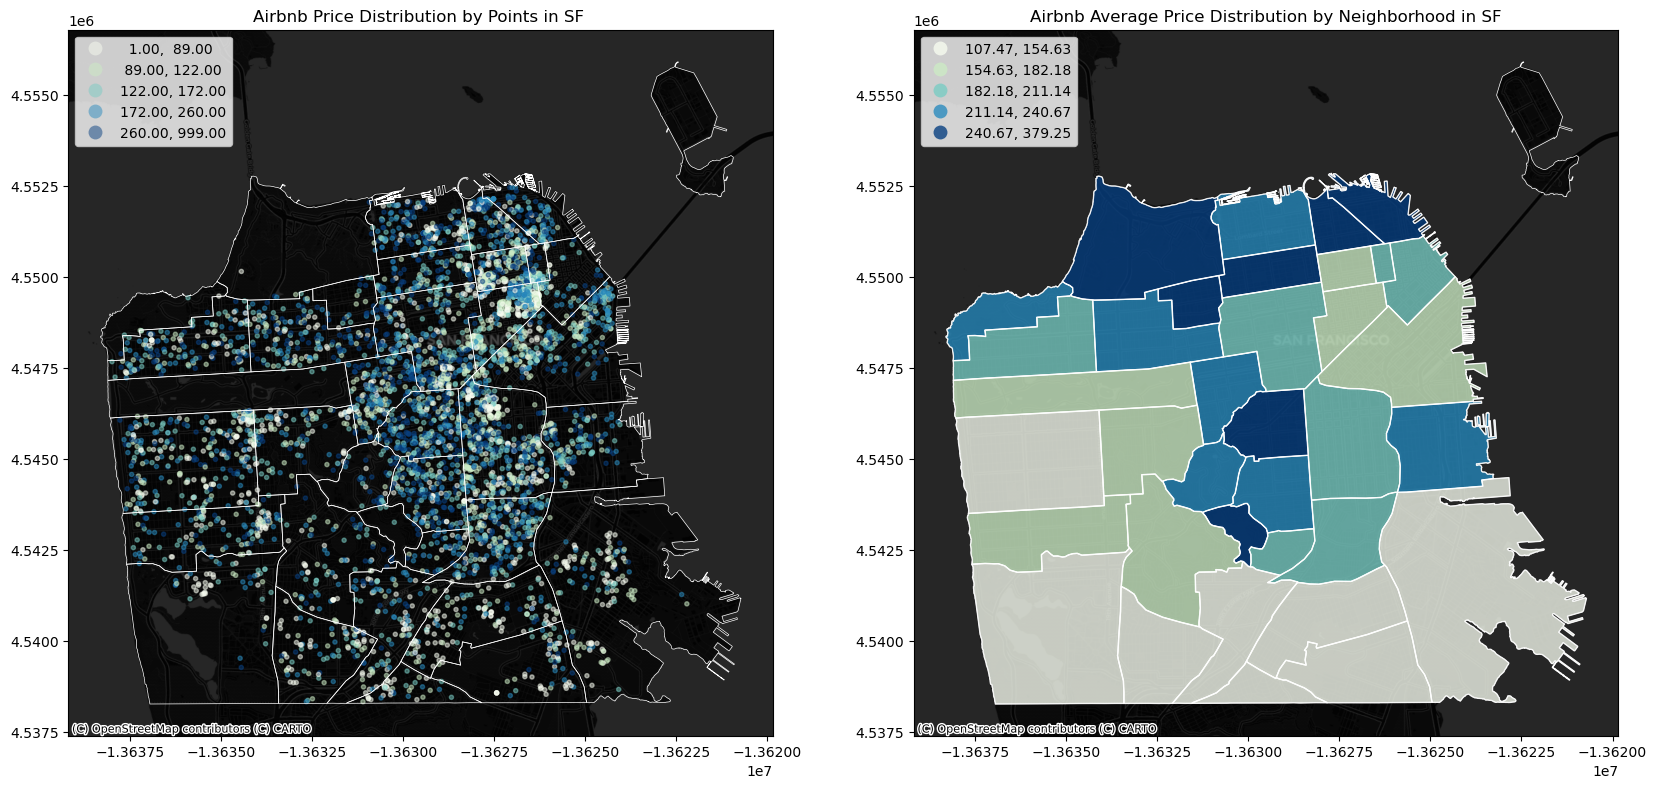

In [247]:
# Plot two columns
fig, axs = plt.subplots(ncols=2, figsize=(20,10), facecolor="white")

# Predicted values
airbnb_gpd.plot(ax=axs[0], 
                column='price', 
                marker='.',
                cmap="GnBu",
                alpha=0.5,
                legend=True,
                legend_kwds=dict(loc='upper left'),
                scheme="Quantiles",
                k=5)
nhood.plot(ax=axs[0], edgecolor='white', linewidth=0.5, facecolor='none')
ctx.add_basemap(ax=axs[0], crs=airbnb_gpd.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[0].set_title("Airbnb Price Distribution by Points in SF ",size=12)


# Actual values
group.plot(ax=axs[1],
           column="price",
           edgecolor="white",
           alpha=0.8,
           legend=True,
           legend_kwds=dict(loc='upper left'),
           cmap="GnBu",
           scheme="Quantiles",
           k=5)
nhood.plot(ax=axs[1], edgecolor='white', linewidth=0.5, facecolor='none')
ctx.add_basemap(ax=axs[1], crs=group.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[1].set_title("Airbnb Average Price Distribution by Neighborhood in SF",size=12)



# Format
ax.set_title("Average Airbnb Price by neighborhood, SF (Quantiles: k = 5)",size=15)
ax.set_axis_off()
ax.set_aspect("equal")
plt.savefig('./diagram/detail/price_average_nhood',bbox_inches='tight')

In [259]:
airbnb_gpd

id       neighbourhood  host_response_rate  \
0                    958    Western Addition               100.0   
1                   5858      Bernal Heights                80.0   
2                   8142      Haight Ashbury               100.0   
3                   8339    Western Addition               100.0   
4                   8739             Mission               100.0   
...                  ...                 ...                 ...   
7316  954536562110561560      Outer Richmond               100.0   
7325  956723436929813205  West of Twin Peaks               100.0   
7335  958209683596711862    Western Addition                96.0   
7361  963333324421869755            Parkside               100.0   
7366  964458312280841640  Financial District               100.0   

      host_acceptance_rate host_identity_verified   latitude   longitude  \
0                    100.0                      t  37.770280 -122.433170   
1                     71.0                      t  37.744740 -122.420890   
2                     88.0                      t  37.765550 -122.452130   
3                      0.0                      t  37.775640 -122.436420   
4                     96.0                      t  37.760300 -122.421970   
...                    ...                    ...        ...         ...   
7316                 100.0                      t  37.775050 -122.504760   
7325                 100.0                      t  37.739010 -122.459720   
7335                 100.0                      t  37.775320 -122.426232   
7361                  96.0                      t  37.744915 -122.470770   
7366                  97.0                      t  37.788338 -122.393760   

      price  accommodates instant_bookable        room_type  beds  \
0       187             3                f  Entire home/apt   2.0   
1       235             4                f  Entire home/apt   2.0   
2        56             1                f     Private room   1.0   
3       480             2                f  Entire home/apt   1.0   
4       122             3                f     Private room   1.0   
...     ...           ...              ...              ...   ...   
7316    156             2                t  Entire home/apt   1.0   
7325     85             2                f     Private room   1.0   
7335    349             8                f  Entire home/apt   4.0   
7361    292             6                f  Entire home/apt   3.0   
7366    315             4                f  Entire home/apt   1.0   

      number_of_reviews  number_of_reviews_l30d  review_scores_rating  \
0                   405                       1                  4.87   
1                   111                       0                  4.88   
2                    10                       0                  4.70   
3                    28                       0                  4.87   
4                   792                       5                  4.92   
...                 ...                     ...                   ...   
7316                  1                       1                  5.00   
7325                  2                       2                  5.00   
7335                  1                       1                  5.00   
7361                  1                       1                  5.00   
7366                  1                       1                  5.00   

      reviews_per_month  calculated_host_listings_count  minimum_nights  \
0                  2.36                               1               2   
1                  0.64                               1              30   
2                  0.09                              15              32   
3                  0.16                               2               5   
4                  4.62                               2               1   
...                 ...                             ...             ...   
7316               1.00                               2      

## 2.2 Feature Engineering

### 2.2.1 Current Feature Investigation

<Axes: >

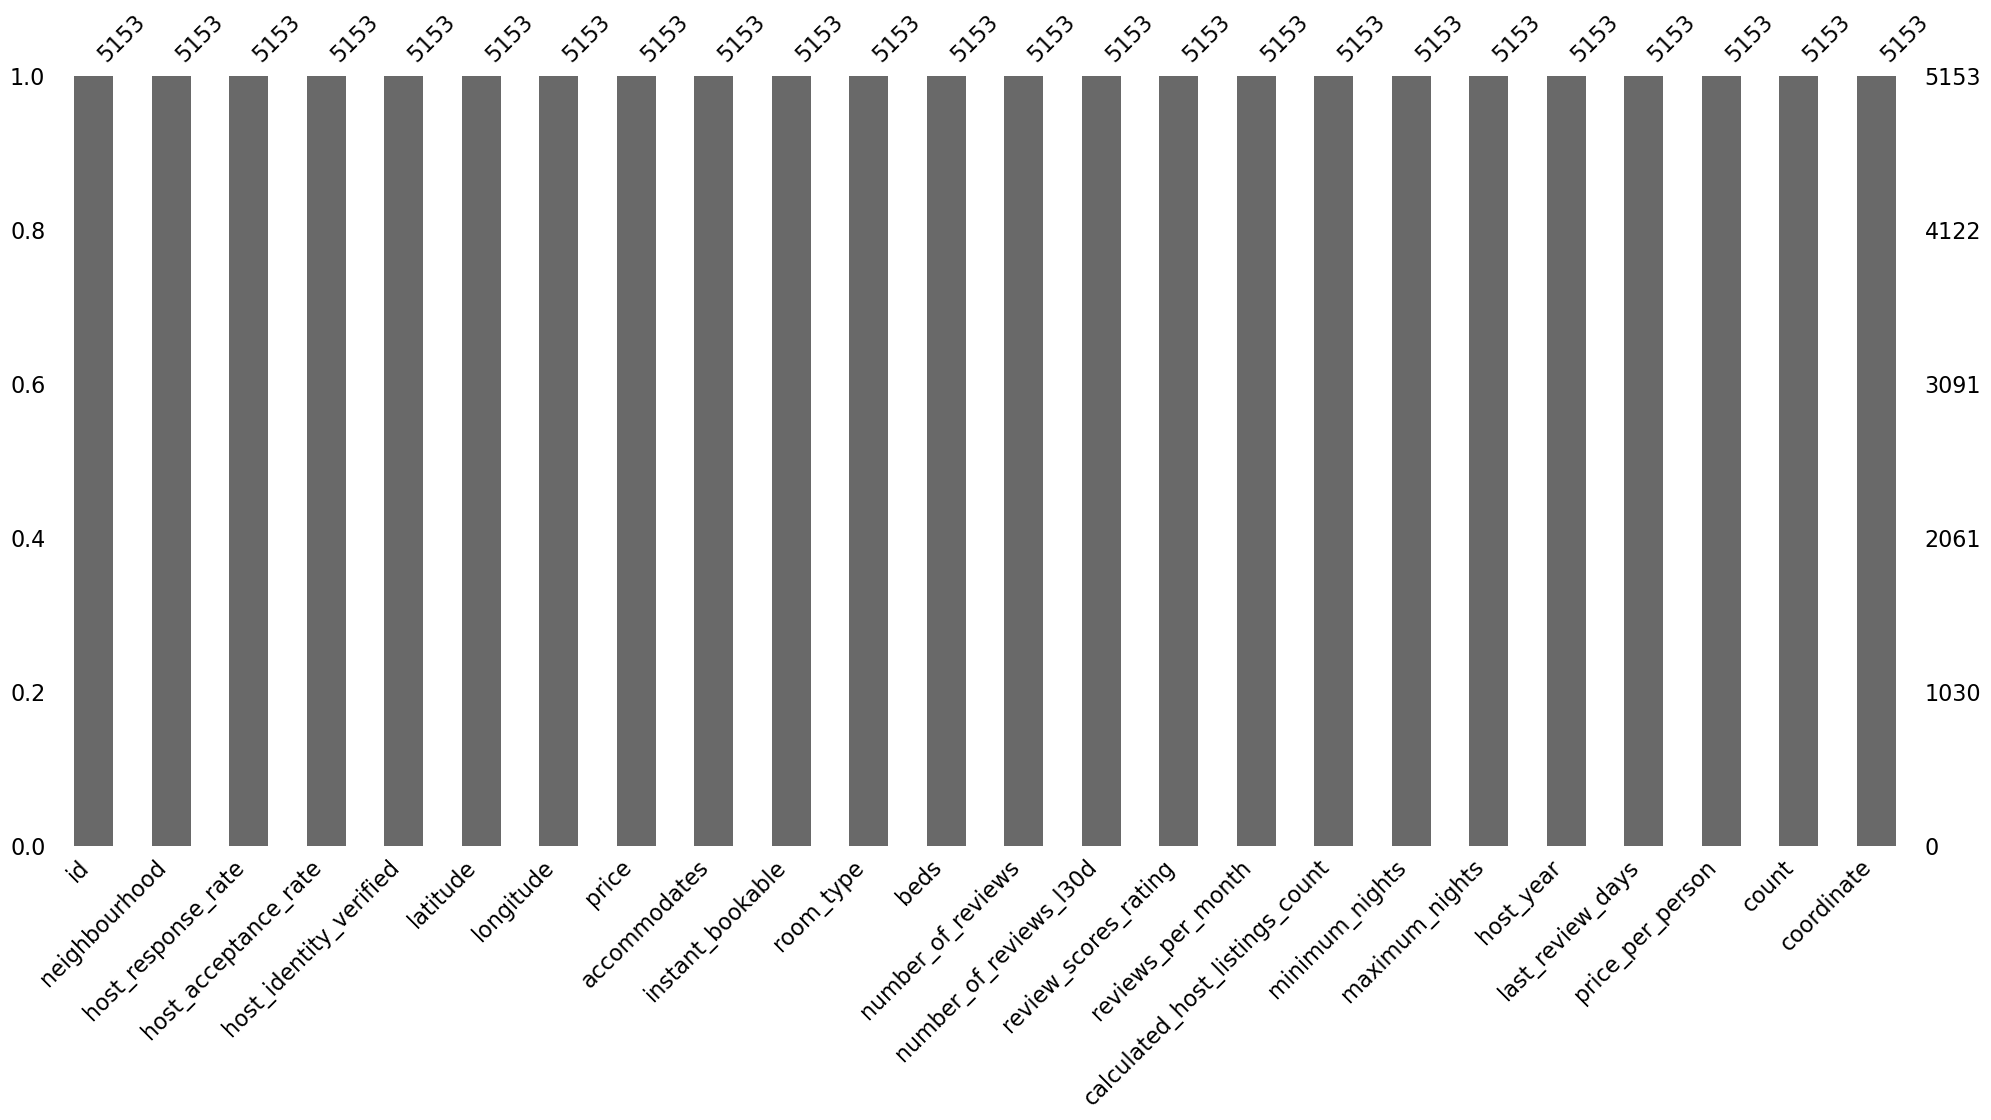

In [93]:
# ==> Firstly, we investigate distribution of each feature

import missingno as msno
msno.bar(airbnb_gpd[airbnb.columns])

### 2.2.2 Feature Collect

Data Source: https://www.sf.gov/departments/city-administrator/datasf

Add the following XX datasets:
- Crime
- 311
- Civic Art Collection
- Recreation and Parks Properties
- Bicycle Parking
- Restaurant

In [ ]:
import requests

In [150]:
# ==> 1.0 Add Crime data
# Get data during URL
url_crime = "https://data.sfgov.org/resource/tmnf-yvry.json?$query=SELECT%20pdid%2C%20incidntnum%2C%20incident_code%2C%20category%2C%20descript%2C%20dayofweek%2C%20date%2C%20time%2C%20pddistrict%2C%20resolution%2C%20address%2C%20x%2C%20y%2C%20location%20ORDER%20BY%20%3Aid%20ASC"
response = requests.get(url_crime)
data = response.json()
crime = pd.DataFrame(data)
# Extract 'Latitude' and  'Longitude' from the original dataset
old_cols = ['y', 'x']
new_cols = ['Latitude', 'Longitude']
crime = crime[old_cols].copy()
crime.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)
# Convert the dataset into geodataframe
crime[["Latitude","Longitude"]] = crime[["Latitude","Longitude"]].astype(float)
crime["geometry"]=list(zip(crime["Longitude"],crime["Latitude"]))
crime["geometry"]=crime["geometry"].apply(Point)
crime=gpd.GeoDataFrame(crime,geometry="geometry",crs={'init': 'epsg:4326'}).to_crs(epsg=3857).dropna()


# ==> 2.0 Add 311 data
# Get data during URL
url_311 = "https://data.sfgov.org/resource/vw6y-z8j6.json?$query=SELECT%20service_request_id%2C%20requested_datetime%2C%20closed_date%2C%20updated_datetime%2C%20status_description%2C%20status_notes%2C%20agency_responsible%2C%20service_name%2C%20service_subtype%2C%20service_details%2C%20address%2C%20street%2C%20supervisor_district%2C%20neighborhoods_sffind_boundaries%2C%20police_district%2C%20lat%2C%20long%2C%20point%2C%20source%2C%20media_url%2C%20bos_2012%20ORDER%20BY%20service_request_id%20DESC"
response = requests.get(url_311)
data = response.json()
data_311 = pd.DataFrame(data)
# Extract 'Latitude' and  'Longitude' from the original dataset
old_cols = ['lat', 'long']
new_cols = ['Latitude', 'Longitude']
data_311 = data_311[old_cols].copy()
data_311.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)
# Convert the dataset into geodataframe
data_311[["Latitude","Longitude"]] = data_311[["Latitude","Longitude"]].astype(float)
data_311["geometry"]=list(zip(data_311["Longitude"],data_311["Latitude"]))
data_311["geometry"]=data_311["geometry"].apply(Point)
data_311=gpd.GeoDataFrame(data_311,geometry="geometry",crs={'init': 'epsg:4326'}).to_crs(epsg=3857).dropna()


# ==> 3.0 Add Civic Art Collection data
# Get data during URL
url_art = "https://data.sfgov.org/resource/r7bn-7v9c.json?$query=SELECT%20creation_date%2C%20accession_number%2C%20artist%2C%20credit_line%2C%20display_title%2C%20display_dimensions%2C%20medium%2C%20media_support%2C%20facility%2C%20current_location%2C%20location_description%2C%20street_address_or_intersection%2C%20zip_code%2C%20latitude%2C%20longitude%2C%20number_of_districts%2C%20cultural_districts%2C%20supervisor_district%2C%20the_geom%20ORDER%20BY%20%3Aid%20ASC"
response = requests.get(url_art)
data = response.json()
art = pd.DataFrame(data)
# Extract 'Latitude' and  'Longitude' from the original dataset
old_cols = ['latitude', 'longitude']
new_cols = ['Latitude', 'Longitude']
art = art[old_cols].copy()
art.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)
# Convert the dataset into geodataframe
art[["Latitude","Longitude"]] = art[["Latitude","Longitude"]].astype(float)
art["geometry"]=list(zip(art["Longitude"],art["Latitude"]))
art["geometry"]=art["geometry"].apply(Point)
art=gpd.GeoDataFrame(art,geometry="geometry",crs={'init': 'epsg:4326'}).to_crs(epsg=3857).dropna()


# ==> 4.0 Add Recreation and Parks Properties data
# Get data during URL
url_park = "https://data.sfgov.org/resource/gtr9-ntp6.json"
response = requests.get(url_park)
data = response.json()
park = pd.DataFrame(data)
# Extract 'Latitude' and  'Longitude' from the original dataset
old_cols = ['latitude', 'longitude']
new_cols = ['Latitude', 'Longitude']
park = park[old_cols].copy()
park.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)
# Convert the dataset into geodataframe
park[["Latitude","Longitude"]] = park[["Latitude","Longitude"]].astype(float)
park["geometry"]=list(zip(park["Longitude"],park["Latitude"]))
park["geometry"]=park["geometry"].apply(Point)
park=gpd.GeoDataFrame(park,geometry="geometry",crs={'init': 'epsg:4326'}).to_crs(epsg=3857).dropna()


# ==> 5.0 Add Bicycle Parking data
# Get data during URL
url_bike = "https://data.sfgov.org/resource/hn4j-6fx5.json?$query=SELECT%20objectid%2C%20address%2C%20location%2C%20street%2C%20placement%2C%20racks%2C%20spaces%2C%20globalid%2C%20install_yr%2C%20install_mo%2C%20lat%2C%20lon%2C%20shape%20ORDER%20BY%20%3Aid%20ASC"
response = requests.get(url_bike)
data = response.json()
bike = pd.DataFrame(data)
# Extract 'Latitude' and  'Longitude' from the original dataset
old_cols = ['lat', 'lon']
new_cols = ['Latitude', 'Longitude']
bike = bike[old_cols].copy()
bike.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)
# Convert the dataset into geodataframe
bike[["Latitude","Longitude"]] = bike[["Latitude","Longitude"]].astype(float)
bike["geometry"]=list(zip(bike["Longitude"],bike["Latitude"]))
bike["geometry"]=bike["geometry"].apply(Point)
bike=gpd.GeoDataFrame(bike,geometry="geometry",crs={'init': 'epsg:4326'}).to_crs(epsg=3857).dropna()


# ==> 6.0 Add Restaurant data
# Get data during URL
url_school = "https://data.sfgov.org/resource/pyih-qa8i.json"
response = requests.get(url_school)
data = response.json()
resta = pd.DataFrame(data)
# Extract 'Latitude' and  'Longitude' from the original dataset
old_cols = ['business_latitude', 'business_longitude']
new_cols = ['Latitude', 'Longitude']
resta = resta[old_cols].copy()
resta.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)
# Convert the dataset into geodataframe
resta[["Latitude","Longitude"]] = resta[["Latitude","Longitude"]].astype(float)
resta["geometry"]=list(zip(resta["Longitude"],resta["Latitude"]))
resta["geometry"]=resta["geometry"].apply(Point)
resta=gpd.GeoDataFrame(resta,geometry="geometry",crs={'init': 'epsg:4326'}).to_crs(epsg=3857).dropna()

/Users/watson/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Latitude   Longitude                             geometry
0  90.000000 -120.500000  POINT (-13413998.641 242528680.944)
1  37.770767 -122.421595    POINT (-13627909.564 4547093.357)
2  37.769868 -122.422367    POINT (-13627995.602 4546966.729)
3  37.745745 -122.452717    POINT (-13631374.069 4543570.132)
4  37.712164 -122.448127    POINT (-13630863.178 4538843.604)

### 2.2.3 Feature Add

In [161]:
from sklearn.neighbors import NearestNeighbors

# define a function to extract x/y from dataset
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    x = df.geometry.x
    y = df.geometry.y
    
    return np.column_stack((x, y)) 

# Extract x/y from airbnb
airbnbXY=get_xy_from_geometry(airbnb_gpd)

In [167]:
# ==> 1.0 KNN method of six features via the following 6 steps
# Step1: Extract x/y from crime
# Step2: Initialize the algorithm
# Step3: Fit the algorithm on the "neighbors" dataset
# Step4: Get distances for airbnb to 
# Step5: Average distance to neighbors
# Step6: Set zero distances to be small, but nonzero

# 1.1 KNN of crime
crimeXY=get_xy_from_geometry(crime) 
nbrs = NearestNeighbors(n_neighbors=5) 
nbrs.fit(crimeXY) 
criDists, criIndices = nbrs.kneighbors(airbnbXY) 
avgCriDist_crime = criDists.mean(axis=1)
avgCriDist_crime[avgCriDist_crime==0] = 1e-5 

# 1.2 KNN of 311
data_311XY=get_xy_from_geometry(data_311) 
nbrs = NearestNeighbors(n_neighbors=5) 
nbrs.fit(data_311XY) 
criDists, criIndices = nbrs.kneighbors(airbnbXY) 
avgCriDist_311 = criDists.mean(axis=1)
avgCriDist_311[avgCriDist_311==0] = 1e-5 

# 1.3 KNN of art
artXY=get_xy_from_geometry(art) 
nbrs = NearestNeighbors(n_neighbors=5) 
nbrs.fit(artXY) 
criDists, criIndices = nbrs.kneighbors(airbnbXY) 
avgCriDist_art = criDists.mean(axis=1)
avgCriDist_art[avgCriDist_art==0] = 1e-5 

# 1.4 KNN of park
parkXY=get_xy_from_geometry(park) 
nbrs = NearestNeighbors(n_neighbors=5) 
nbrs.fit(parkXY) 
criDists, criIndices = nbrs.kneighbors(airbnbXY) 
avgCriDist_park = criDists.mean(axis=1)
avgCriDist_park[avgCriDist_park==0] = 1e-5

# 1.5 KNN of bike
bikeXY=get_xy_from_geometry(bike) 
nbrs = NearestNeighbors(n_neighbors=5) 
nbrs.fit(bikeXY) 
criDists, criIndices = nbrs.kneighbors(airbnbXY) 
avgCriDist_bike = criDists.mean(axis=1)
avgCriDist_bike[avgCriDist_bike==0] = 1e-5

# 1.6 KNN of resta
restaXY=get_xy_from_geometry(resta) 
nbrs = NearestNeighbors(n_neighbors=5) 
nbrs.fit(restaXY) 
criDists, criIndices = nbrs.kneighbors(airbnbXY) 
avgCriDist_resta = criDists.mean(axis=1)
avgCriDist_resta[avgCriDist_resta==0] = 1e-5


# ==> 2.0 Calculate log of distances of six features
airbnb_gpd['log_crime'] = np.log10(avgCriDist_crime)
airbnb_gpd['log_311'] = np.log10(avgCriDist_311)
airbnb_gpd['log_art'] = np.log10(avgCriDist_art)
airbnb_gpd['log_park'] = np.log10(avgCriDist_park)
airbnb_gpd['log_bike'] = np.log10(avgCriDist_bike)
airbnb_gpd['log_resta'] = np.log10(avgCriDist_resta)

In [168]:
airbnb_gpd.head()

id     neighbourhood  host_response_rate  host_acceptance_rate  \
0   958  Western Addition               100.0                 100.0   
1  5858    Bernal Heights                80.0                  71.0   
2  8142    Haight Ashbury               100.0                  88.0   
3  8339  Western Addition               100.0                   0.0   
4  8739           Mission               100.0                  96.0   

  host_identity_verified  latitude  longitude  price  accommodates  \
0                      t  37.77028 -122.43317    187             3   
1                      t  37.74474 -122.42089    235             4   
2                      t  37.76555 -122.45213     56             1   
3                      t  37.77564 -122.43642    480             2   
4                      t  37.76030 -122.42197    122             3   

  instant_bookable        room_type  beds  number_of_reviews  \
0                f  Entire home/apt   2.0                405   
1                f  Entire home/apt   2.0                111   
2                f     Private room   1.0                 10   
3                f  Entire home/apt   1.0                 28   
4                f     Private room   1.0                792   

   number_of_reviews_l30d  review_scores_rating  reviews_per_month  \
0                       1                  4.87               2.36   
1                       0                  4.88               0.64   
2                       0                  4.70               0.09   
3                       0                  4.87               0.16   
4                       5                  4.92               4.62   

   calculated_host_listings_count  minimum_nights  maximum_nights  host_year  \
0                               1               2              30       2008   
1                               1              30              60       2009   
2                              15              32              90       2009   
3                               2               5              91       2009   
4                               2               1              26       2009   

   last_review_days  price_per_person  count  \
0               133         62.333333      1   
1              2325         58.750000      1   
2               141         56.000000      1   
3              1634        240.000000      1   
4               119         40.666667      1   

                          coordinate  log_crime   log_311   log_art  log_park  \
0  POINT (-13629198.141 4547024.716)   2.438247  2.473138  2.626526  2.793330   
1  POINT (-13627831.137 4543428.629)   2.386006  2.695961  2.157961  2.722494   
2  POINT (-13631308.758 4546358.628)   2.584913  2.408406  2.950024  2.848271   
3  POINT (-13629559.929 4547779.573)   2.416063  2.463375  2.907497  2.852972   
4  POINT (-13627951.362 4545619.363)   2.365501  2.327283  2.605696  2.718618   

   log_bike  log_resta  
0  2.350033   2.371349  
1  2.092105   1.958029  
2  2.450163   2.683513  
3  2.242407   2.565325  
4  2.174633   2.350898

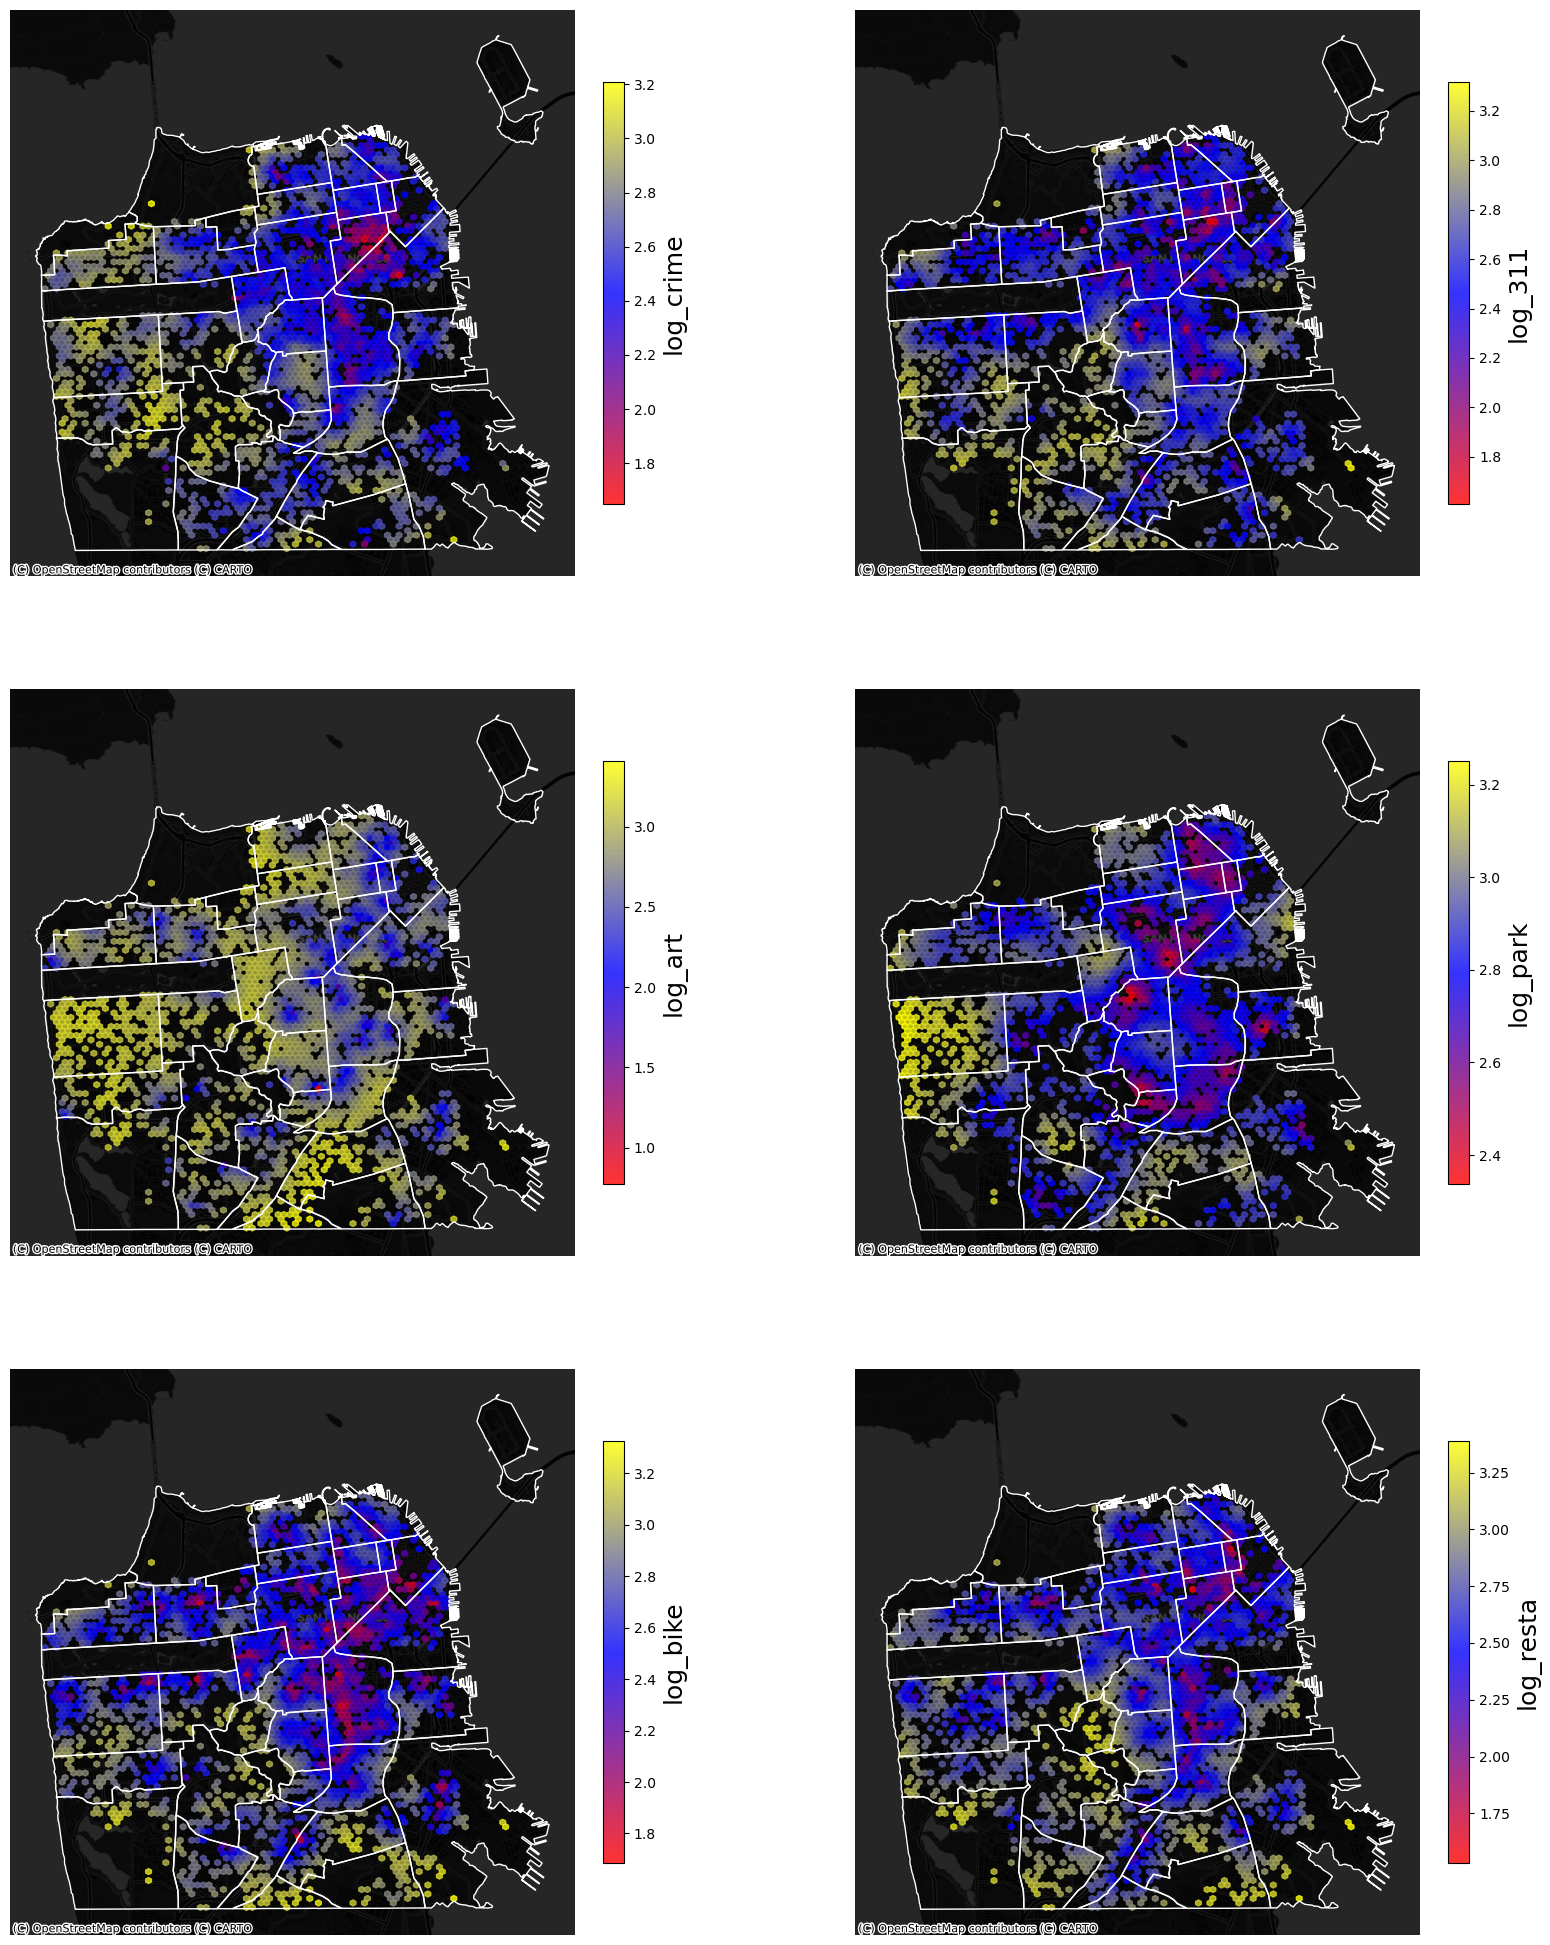

In [172]:
# ==> 3.0 Plot all six features in the same figure
fig, axs = plt.subplots(ncols=2,nrows=3, figsize=(20,25))
import matplotlib.colors as mcolors
colors = [(0.0, "red"), (0.5, "blue"), (1.0, "yellow")]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=256)


# 3.1 log_crime
ax=axs[0][0]
hb=ax.hexbin(airbnbXY[:,0], airbnbXY[:,1], C=airbnb_gpd['log_crime'].values,
             cmap=custom_cmap,gridsize=80,alpha=0.8)
nhood.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1)
ctx.add_basemap(ax=ax, crs=airbnb_gpd.crs, source=ctx.providers.CartoDB.DarkMatter)
plt.colorbar(hb,ax=ax,fraction=0.03,pad=0.04).set_label('log_crime',size=18)
ax.set_axis_off()

# 3.2 log_311
ax=axs[0][1]
hb=ax.hexbin(airbnbXY[:,0], airbnbXY[:,1], C=airbnb_gpd['log_311'].values,
             cmap=custom_cmap,gridsize=80,alpha=0.8)
nhood.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1)
ctx.add_basemap(ax=ax, crs=airbnb_gpd.crs, source=ctx.providers.CartoDB.DarkMatter)
plt.colorbar(hb,ax=ax,fraction=0.03,pad=0.04).set_label('log_311',size=18)
ax.set_axis_off()

# 3.3 log_art
ax=axs[1][0]
hb=ax.hexbin(airbnbXY[:,0], airbnbXY[:,1], C=airbnb_gpd['log_art'].values,
             cmap=custom_cmap,gridsize=80,alpha=0.8)
nhood.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1)
ctx.add_basemap(ax=ax, crs=airbnb_gpd.crs, source=ctx.providers.CartoDB.DarkMatter)
plt.colorbar(hb,ax=ax,fraction=0.03,pad=0.04).set_label('log_art',size=18)
ax.set_axis_off()

# 3.4 log_park
ax=axs[1][1]
hb=ax.hexbin(airbnbXY[:,0], airbnbXY[:,1], C=airbnb_gpd['log_park'].values,
             cmap=custom_cmap,gridsize=80,alpha=0.8)
nhood.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1)
ctx.add_basemap(ax=ax, crs=airbnb_gpd.crs, source=ctx.providers.CartoDB.DarkMatter)
plt.colorbar(hb,ax=ax,fraction=0.03,pad=0.04).set_label('log_park',size=18)
ax.set_axis_off()

# 3.5 log_bike
ax=axs[2][0]
hb=ax.hexbin(airbnbXY[:,0], airbnbXY[:,1], C=airbnb_gpd['log_bike'].values,
             cmap=custom_cmap,gridsize=80,alpha=0.8)
nhood.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1)
ctx.add_basemap(ax=ax, crs=airbnb_gpd.crs, source=ctx.providers.CartoDB.DarkMatter)
plt.colorbar(hb,ax=ax,fraction=0.03,pad=0.04).set_label('log_bike',size=18)
ax.set_axis_off()

# 3.6 log_resta
ax=axs[2][1]
hb=ax.hexbin(airbnbXY[:,0], airbnbXY[:,1], C=airbnb_gpd['log_resta'].values,
             cmap=custom_cmap,gridsize=80,alpha=0.8)
nhood.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1)
ctx.add_basemap(ax=ax, crs=airbnb_gpd.crs, source=ctx.providers.CartoDB.DarkMatter)
plt.colorbar(hb,ax=ax,fraction=0.03,pad=0.04).set_label('log_resta',size=18)
ax.set_axis_off()

plt.savefig('./diagram/features_collected',bbox_inches='tight')

In [173]:
# ==> 4.0 Add the lagged sales variable

nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(airbnbXY)
priceDists, priceIndices = nbrs.kneighbors(airbnbXY)

# the sales for the stations from original data frame
price = airbnb_gpd['price'].values

# get the trips for the 5 nearest neighbors (ignoring first match)
neighboring_price =  price[priceIndices[:,1:]]

# add to features
airbnb_gpd['LaggedPrice'] = neighboring_price.mean(axis=1)

id     neighbourhood  host_response_rate  host_acceptance_rate  \
0   958  Western Addition               100.0                 100.0   
1  5858    Bernal Heights                80.0                  71.0   
2  8142    Haight Ashbury               100.0                  88.0   
3  8339  Western Addition               100.0                   0.0   
4  8739           Mission               100.0                  96.0   

  host_identity_verified  latitude  longitude  price  accommodates  \
0                      t  37.77028 -122.43317    187             3   
1                      t  37.74474 -122.42089    235             4   
2                      t  37.76555 -122.45213     56             1   
3                      t  37.77564 -122.43642    480             2   
4                      t  37.76030 -122.42197    122             3   

  instant_bookable        room_type  beds  number_of_reviews  \
0                f  Entire home/apt   2.0                405   
1                f  Entire home/apt   2.0                111   
2                f     Private room   1.0                 10   
3                f  Entire home/apt   1.0                 28   
4                f     Private room   1.0                792   

   number_of_reviews_l30d  review_scores_rating  reviews_per_month  \
0                       1                  4.87               2.36   
1                       0                  4.88               0.64   
2                       0                  4.70               0.09   
3                       0                  4.87               0.16   
4                       5                  4.92               4.62   

   calculated_host_listings_count  minimum_nights  maximum_nights  host_year  \
0                               1               2              30       2008   
1                               1              30              60       2009   
2                              15              32              90       2009   
3                               2               5              91       2009   
4                               2               1              26       2009   

   last_review_days  price_per_person  count  \
0               133         62.333333      1   
1              2325         58.750000      1   
2               141         56.000000      1   
3              1634        240.000000      1   
4               119         40.666667      1   

                          coordinate  log_crime   log_311   log_art  log_park  \
0  POINT (-13629198.141 4547024.716)   2.438247  2.473138  2.626526  2.793330   
1  POINT (-13627831.137 4543428.629)   2.386006  2.695961  2.157961  2.722494   
2  POINT (-13631308.758 4546358.628)   2.584913  2.408406  2.950024  2.848271   
3  POINT (-13629559.929 4547779.573)   2.416063  2.463375  2.907497  2.852972   
4  POINT (-13627951.362 4545619.363)   2.365501  2.327283  2.605696  2.718618   

   log_bike  log_resta  LaggedPrice  
0  2.350033   2.371349       370.25  
1  2.092105   1.958029       104.75  
2  2.450163   2.683513        79.75  
3  2.242407   2.565325       222.00  
4  2.174633   2.350898       167.00

## 2.3 Correlation Analysis

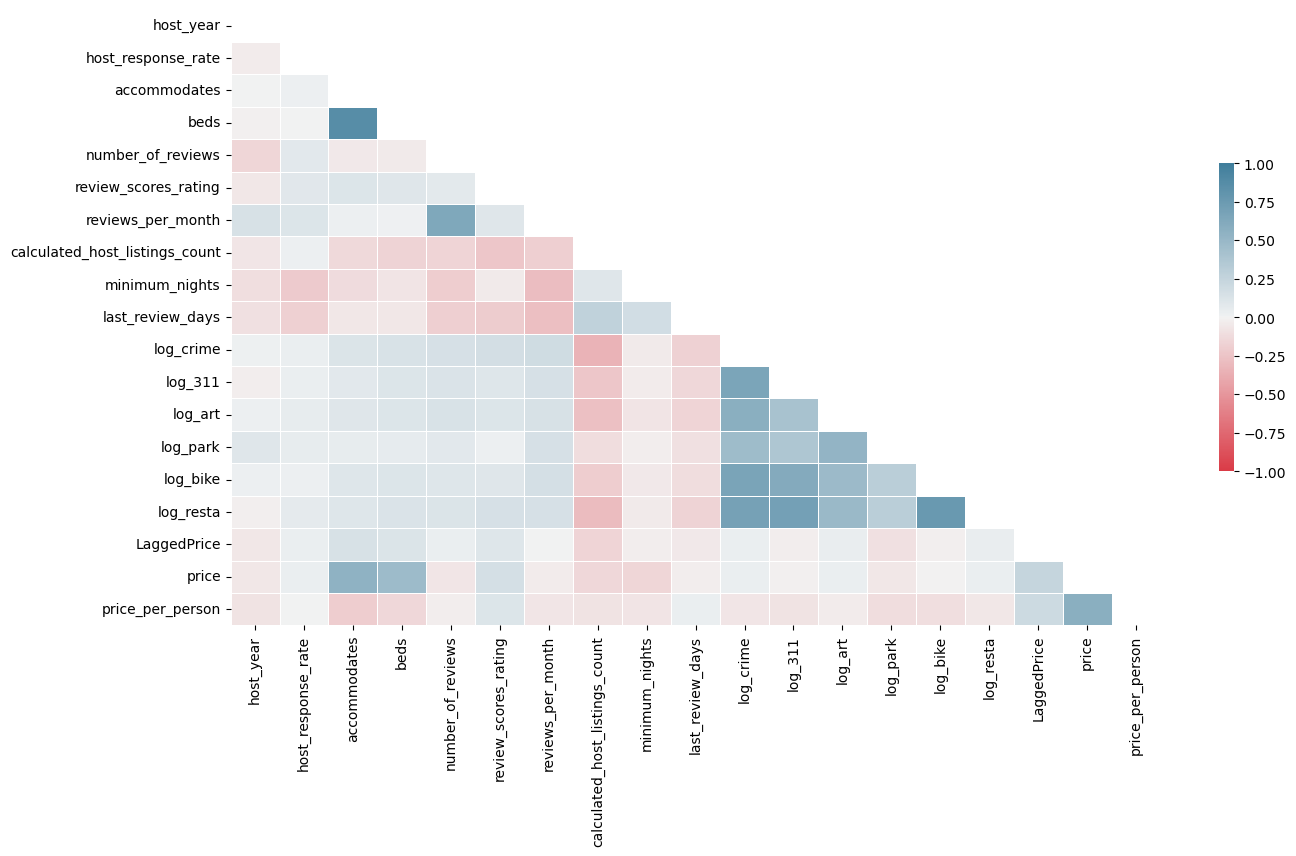

In [180]:
import seaborn as sns
value = bool(True)

feature_cols = [
     'host_year', 
     'host_response_rate',
     'accommodates',
     'beds',
     'number_of_reviews',
     'review_scores_rating',
     'reviews_per_month',
     'calculated_host_listings_count',
     'minimum_nights',
     'last_review_days',
     'log_crime',
     'log_311',
     'log_art',
     'log_park',
     'log_bike',
     'log_resta',
     'LaggedPrice',
     'price',
     'price_per_person'
     ]

# Initialize the figure and axes
fx, ax = plt.subplots(figsize=(15, 8))

# Compute the correlation matrix
corr = airbnb_gpd[feature_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)  # Use bool directly instead of np.bool
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 230, as_cmap=True)

heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .5})
figure = heatmap.get_figure() 
figure.savefig("./diagram/correlation.png", bbox_inches='tight')

## 2.4 Model Building

In [267]:
cols_price=[
     'host_year',  
     'host_response_rate',
     'accommodates',
     'beds',
     'number_of_reviews',
     'review_scores_rating',
     'reviews_per_month',
     'calculated_host_listings_count',
     'minimum_nights',
     'last_review_days',
     'log_crime',
     'log_311',
     'log_art',
     'log_park',
     'log_bike',
     'log_resta',
     'LaggedPrice',
     'price',
     'host_identity_verified',
     'instant_bookable',
     'neighbourhood',
     'room_type',
     'coordinate'
     ]

price=airbnb_gpd[cols_price].dropna()

In [268]:
# Use a 70/30% training/test split
from sklearn.model_selection import train_test_split
import numpy as np

train_set, test_set = train_test_split(price, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["price"])
y_test = np.log(test_set["price"])

In [269]:
# Set up a pipeline that includes both numerical columns and categorical columns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor


# Numerical columns
num_cols = [
     'host_year', 
     'host_response_rate',
     'accommodates',
     'beds',
     'number_of_reviews',
     'review_scores_rating',
     'reviews_per_month',
     'calculated_host_listings_count',
     'minimum_nights',
     'last_review_days',
     'log_crime',
     'log_311',
     'log_art',
     'log_park',
     'log_bike',
     'log_resta',
     'LaggedPrice'
]
# Categorical columns
cat_cols = [ 'host_identity_verified',
             'instant_bookable',
             'neighbourhood',
             'room_type'
           ]


# Set up the column transformer with two transformers
# Scale the numerical columns and one-hot 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

#Initialize the pipeline
regressor = make_pipeline(
    preprocessor, RandomForestRegressor(n_estimators=10, random_state=42)
)

In [270]:
# Evaluate the score on the test set using the best_params_ 
regressor = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100,max_depth=13,random_state=42))

# Fit the training set
regressor.fit(train_set, y_train);

#  the test score
print(f"Testing Score = {regressor.score(test_set, y_test)}")

Testing Score = 0.34280431620306995


## 2.6 Predict

In [271]:
import hvplot.pandas

def plot_feature_importances(regr, num_cols, preprocessor, top=20, **kwargs):
    """
    Utility function to plot the feature importances from the input
    random forest regressor
    """
    # The one-hot step
    ohe = preprocessor.named_transformers_["cat"]

    # One column for each category type!
    ohe_cols = ohe.get_feature_names_out()

    # Full list of columns is numerical + one-hot
    features = num_cols + list(ohe_cols)

    # The regressor
    regressor = regr["randomforestregressor"]

    # Create the dataframe with importances
    importance = pd.DataFrame(
        {"Feature": features, "Importance": regressor.feature_importances_}
    )

    # Sort importance in descending order and get the top
    importance = importance.sort_values("Importance", ascending=False).iloc[:top]

    # Plot
    return importance.hvplot.barh(x="Feature", y="Importance",line_color="white",color="#71c9ce", flip_yaxis=True, **kwargs)

imp=plot_feature_importances(regressor, num_cols, preprocessor, top=30, height=500)
hvplot.save(imp, './diagram/importance_bar.html')
imp

:Bars   [Feature]   (Importance)

In [272]:
# Predictions for log of total trip counts
log_predictions = regressor.predict(test_set)

# Convert the predicted test values from log
test_set['prediction'] = np.exp(log_predictions)
test_set['percent_error']=(test_set['prediction']-test_set['price'])/test_set['prediction']
test_set['abs_percent_error']=abs(test_set['percent_error'])


# calculate the airbnb count by neighborhood
abs_nei=test_set.groupby(["neighbourhood"])["abs_percent_error"].mean()
abs_nei=pd.DataFrame(abs_nei).reset_index()

abs_nei=nhood.merge(abs_nei,on="neighbourhood")

In [273]:
test_set

host_year  host_response_rate  accommodates  beds  number_of_reviews  \
5972       2020               100.0             4   2.0                  2   
620        2014               100.0             6   3.0                 39   
4261       2020               100.0             2   1.0                 13   
3719       2020               100.0             6   3.0                  8   
5336       2017               100.0             6   3.0                  1   
...         ...                 ...           ...   ...                ...   
3944       2012               100.0             1   1.0                  7   
1316       2013               100.0             5   5.0                121   
6262       2022               100.0             8   4.0                  2   
3351       2016               100.0             2   1.0                  4   
2438       2018               100.0             4   2.0                116   

      review_scores_rating  reviews_per_month  calculated_host_listings_count  \
5972                  5.00               0.19                              14   
620                   4.89               0.35                               1   
4261                  5.00               0.43                               4   
3719                  5.00               1.83                               2   
5336                  5.00               0.06                               8   
...                    ...                ...                             ...   
3944                  4.71               0.24                              23   
1316                  4.88               1.35                               7   
6262                  5.00               0.28                               2   
3351                  4.75               0.09                              48   
2438                  4.81               1.83                               3   

      minimum_nights  last_review_days  log_crime   log_311   log_art  \
5972               2               340   2.270763  2.064503  2.231732   
620                2               340   2.829116  2.932763  2.940149   
4261              30               201   2.572000  2.459310  2.951267   
3719               3               121   2.313734  2.781310  2.458128   
5336              30               588   2.772270  3.272024  3.248074   
...              ...               ...        ...       ...       ...   
3944              30               202   2.472840  2.399109  2.745379   
1316              30               256   2.115881  2.584117  2.403650   
6262              30               246   2.668124  2.671466  2.704201   
3351               2               234   2.274353  1.881382  2.490948   
2438               1               114   2.737564  2.743015  3.124985   

      log_park  log_bike  log_resta  LaggedPrice  price  \
5972  2.565864  2.460853   2.479059       150.75    131   
620   2.848138  3.032383   3.220961       353.50    621   
4261  2.838103  2.635427   2.576596       231.50    200   
3719  2.729949  2.369446   2.568670       298.00    675   
5336  3.079585  3.237465   3.353485       100.00    194   
...        ...       ...        ...          ...    ...   
3944  2.608093  2.462304   2.346706       136.50     74   
1316  2.645915  2.202797   2.473800        97.00    500   
6262  2.753143  2.675993   2.598566       258.75    169   
3351  2.568636  2.560734   2.114605       120.00     95   
2438  3.067772  2.918207   2.698198        88.75    139   

     host_identity_verified instant_bookable          neighbourhood  \
5972                      t                f  Downtown/Civic Center   
620                       t                f             Twin Peaks   
4261                      t                f        Pacific Heights   
3719                      f                f                Mission   
5336                      t                t                Bayview   
...                     ...              ...                    ...   
3944         

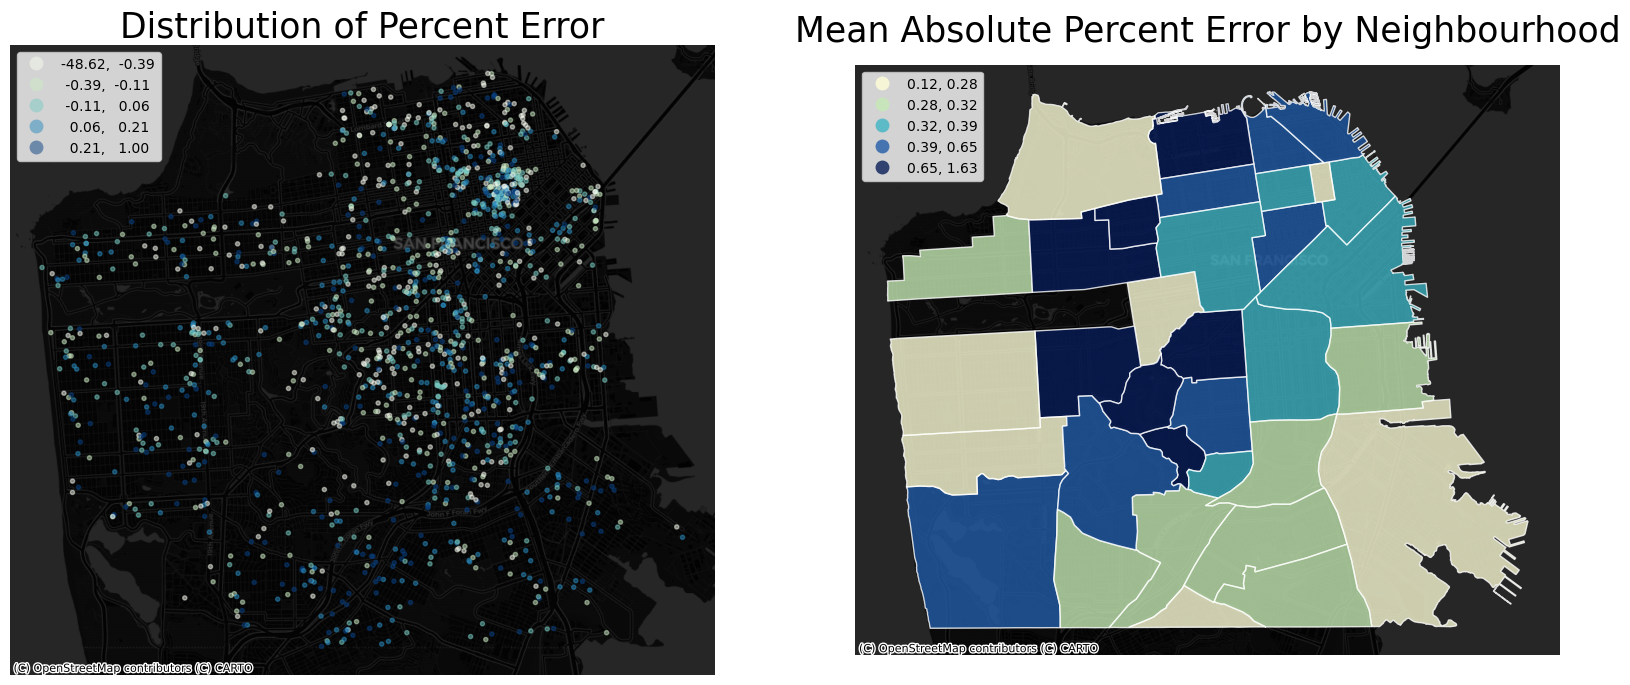

In [277]:
# Plot two columns
import contextily as ctx
fig, axs = plt.subplots(ncols=2, figsize=(20,10), facecolor="white")


# Predicted values
test_set.plot(ax=axs[0], column='percent_error', marker='.',cmap="GnBu",alpha=0.5,
            legend=True,legend_kwds=dict(loc='upper left'),scheme="Quantiles",k=5)
ctx.add_basemap(ax=axs[0], crs=test_set.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[0].set_title("Distribution of Percent Error",size=25)


# Actual values
abs_nei.plot(ax=axs[1],column="abs_percent_error",edgecolor="white",alpha=0.8,
              legend=True,legend_kwds=dict(loc='upper left'),cmap="YlGnBu",scheme="Quantiles",k=5)
ctx.add_basemap(ax=axs[1], crs=test_set.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[1].set_title("Mean Absolute Percent Error by Neighbourhood",size=25)



axs[0].set_axis_off()
axs[1].set_axis_off()
plt.savefig('./diagram/model_validation.png',bbox_inches='tight')